# IMPORT

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import numpy as np
import csv
import io
import os
from IPython.display import Audio
from scipy.io import wavfile
import matplotlib.pyplot as plt
import scipy

# COLLEGAMENTO AL DRIVE

In [2]:
from google.colab import drive
drive.mount("/content/drive")

!ls '/content/drive/My Drive/SonART/Demo'

Mounted at /content/drive
'asmr EGG CRACKING sound.mp3'
'Bird Flapping Wings Sound Effect.mp3'
'Busy Street [Sound Effect].mp3'
 cat-purring-68797.mp3
 egg-crack5-104555.mp3
 egg-cracking-6844.mp3
'Egg Shell Crack Sound Effect - Egg Cracking sound.mp3'
'Heart Beat [SOUND EFFECT].mp3'
'Hungry Cat Sound Effects - Hungry Cat Meowing Sound shorts.mp3'
'Long Mud Pour Sound Effect.mp3'
'Meow Sound Effect.mp3'
' Royalty-Free Sounds.mp3'
'Seagull - Sound Effect.mp3'
'seagull sound.mp3'
'Sea Waves - Sound Effect.mp3'
'SonART Demo v1.wav'
'SonART Demo v2.wav'
'SonART Demo v3.wav'
'SonART Demo v4.wav'
'SonART Demo v5.wav'
'SonART Demo v6.wav'
'SonART Demo v7.wav'
'SonART Demo v8.wav'
'Sound effect - Campane - Bells.mp3'
 splash-6213.mp3


# CREAZIONE E SALVATAGGIO DEL MODELLO PER LA CLASSIFICAZIONE AUDIO

In [19]:
# Nome della directory dove il modello sarà salvato
MODEL_DIR = "/content/drive/My Drive/SonART/saved_model"
MODEL_PATH = os.path.join(MODEL_DIR, "yamnet")

# Funzione per ottenere il modello
def get_model():
    if os.path.exists(MODEL_PATH):
        print("Modello trovato. Caricamento del modello salvato...")
        # Carica il modello salvato (SavedModel)
        model = tf.saved_model.load(MODEL_PATH)
    else:
        print("Modello non trovato. Caricamento iniziale dal TensorFlow Hub...")
        # Scarica il modello da TensorFlow Hub
        model = hub.load('https://tfhub.dev/google/yamnet/1')

        # Salva il modello per utilizzi futuri
        print("Salvataggio del modello nella directory specificata...")
        os.makedirs(MODEL_DIR, exist_ok=True)
        tf.saved_model.save(model, MODEL_PATH)

    return model

# Utilizzo del modello
model = get_model()

# Poiché è un modello TensorFlow puro, non può utilizzare il metodo summary()
print("Modello caricato correttamente.")



Modello trovato. Caricamento del modello salvato...
Modello caricato correttamente.


In [4]:
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_map_csv = io.StringIO(class_map_csv_text)
  class_names = [display_name for (class_index, mid, display_name) in csv.reader(class_map_csv)]
  class_names = class_names[1:]  # Skip CSV header
  return class_names

# SCELTA DEL FILE AUDIO DA PROCESSARE

In [5]:
audio_path = "/content/drive/My Drive/SonART/Demo/splash-6213.mp3"
print(os.path.exists(audio_path))  # Deve stampare True

True


In [18]:
# Controllo che il file esista
if not os.path.exists(audio_path):
    raise FileNotFoundError(f"Il file non esiste: {audio_path}")

# Caricare il file audio con una frequenza di campionamento a 16 kHz
waveform, sr = librosa.load(audio_path, sr=16000, mono=True)

# Normalizzare i valori nella gamma [-1.0, 1.0]
waveform = np.clip(waveform, -1.0, 1.0).astype(np.float32)

# Assicurarsi che il waveform sia un array numpy (può essere opzionale in molti casi)
waveform = np.asarray(waveform, dtype=np.float32)

# Mostrare dettagli
duration = len(waveform)/sr
print(f'Sample rate: {sr} Hz')
print(f'Total duration: {duration:.2f}s')
print(f"Forma del waveform: {waveform.shape}, Tipo: {waveform.dtype}")

Audio(waveform, rate=sr)

Sample rate: 16000 Hz
Total duration: 1.39s
Forma del waveform: (22272,), Tipo: float32


In [7]:
# **Specifica la durata dei segmenti in secondi**
segment_duration = 3 # Durata del segmento in secondi (esempio: 2 secondi)
hop_duration = 1   # Durata del salto tra segmenti in secondi (esempio: 1 secondo)

# Calcolare la lunghezza di ogni segmento in campioni
segment_length = int(segment_duration * sr)
hop_length = int(hop_duration * sr)

# Dividere il waveform in segmenti con il salto specificato
segments = []
for start in range(0, len(waveform) - segment_length + 1, hop_length):
    segment = waveform[start:start + segment_length]
    segments.append(segment)

# Aggiungere l'ultimo segmento se non coperto dal ciclo (padding se necessario)
if len(waveform) % hop_length != 0:
    last_segment = waveform[-segment_length:]
    segments.append(last_segment)

# Trasformare i segmenti in un array numpy
segments = np.stack(segments)

# Mostrare dettagli
print(f"Numero di segmenti: {len(segments)}, Forma di ogni segmento: {segments[0].shape}")

Numero di segmenti: 1, Forma di ogni segmento: (22272,)


# MODELLO SENZA MODIFICHE

In [8]:
# Run the model, check the output.
for segment in segments:
  scores, embeddings, log_mel_spectrogram = model(segment)
  scores.shape.assert_is_compatible_with([None, 521])
  embeddings.shape.assert_is_compatible_with([None, 1024])
  log_mel_spectrogram.shape.assert_is_compatible_with([None, 64])

  class_map_path = model.class_map_path().numpy()
  class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))
  print(class_names[scores.numpy().mean(axis=0).argmax()])

Liquid


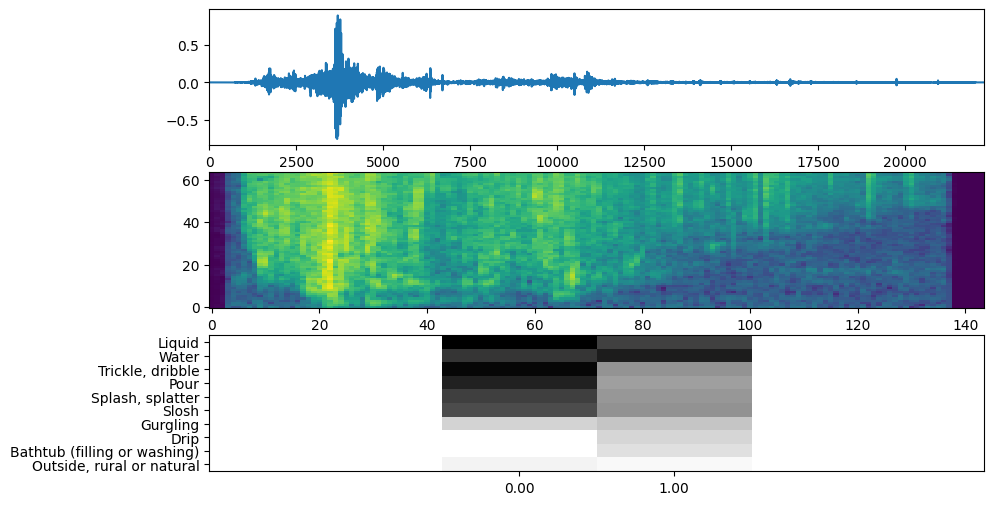

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Supponiamo che 'scores', 'embeddings', 'log_mel_spectrogram' siano già definiti
scores, embeddings, log_mel_spectrogram = model(waveform)

spectrogram_np = log_mel_spectrogram.numpy()
scores_np = scores.numpy()

plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Assicurarsi che scores non sia vuoto
if scores.shape[0] == 0:
    raise ValueError("scores è vuoto. Controlla l'input del modello.")

# Supponiamo che 'class_names' sia la lista dei nomi delle classi.

# Calcolare il padding per le finestre
patch_padding = (segment_duration / 2) / hop_duration

# Calcolare i secondi per l'asse X (tempo per ogni finestra)
time_axis = np.arange(0, scores.shape[0] * hop_duration, hop_duration)

# Calcolare la media dei punteggi per ciascuna classe
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]

# Creare il grafico
plt.subplot(3, 1, 3)  # Sottogruppo 3 della griglia 3x1
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# Impostare i limiti dell'asse X con il padding
plt.xlim([-patch_padding - 0.5, scores.shape[0] + patch_padding - 0.5])

# Etichettare le classi top_n sull'asse Y
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])

# Evitare ZeroDivisionError assicurandosi che il passo sia >= 1
num_points = scores.shape[0]
step = max(1, num_points // 10)

# Etichettare l'asse X con i secondi (tempo)
plt.xticks(np.arange(0, num_points, step),
           labels=[f"{time:.2f}" for time in time_axis[::step]])

# Impostare i limiti dell'asse Y per centrare le etichette delle classi
plt.ylim(-0.5 + np.array([top_n, 0]))

# Mostrare il grafico
plt.show()

# MODELLO CON LABEL BANNATI

In [11]:
for segment in segments:
  # Caricamento dei dati dal modello (come nel tuo codice)
  scores, embeddings, log_mel_spectrogram = model(segment)

  # Verifica della forma degli scores
  scores.shape.assert_is_compatible_with([None, 521])
  embeddings.shape.assert_is_compatible_with([None, 1024])
  log_mel_spectrogram.shape.assert_is_compatible_with([None, 64])

  # Caricamento della mappa delle classi
  class_map_path = model.class_map_path().numpy()
  class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))

  # Definisci le classi da escludere (nomi o indici delle classi)
  exclude_classes = ['Animal', 'Silence', 'Music', 'Vehicle', 'Environmental noise',"Domestic animals, pets"]
  exclude_indices = [class_names.index(class_name) for class_name in exclude_classes]

  # Convertiamo scores in un array NumPy per manipolarlo
  scores_np = scores.numpy()

  # Impostiamo i punteggi delle classi da escludere a un valore molto basso (es. -1)
  scores_np[:, exclude_indices] = -1

  # Ora scegliamo la classe con il punteggio maggiore tra quelle rimanenti
  mean_scores = np.mean(scores_np, axis=0)

  # Troviamo la classe con il punteggio massimo
  predicted_class_index = np.argmax(mean_scores)

  # Verifica che il punteggio della classe predetta sia maggiore di zero
  if mean_scores[predicted_class_index] > 0:
      predicted_class = class_names[predicted_class_index]
  else:
      predicted_class = "Null"  # Se il punteggio è zero o negativo, restituiamo "Null"

  # Stampa della classe predetta
  print(f'Classe predetta: {predicted_class}')


Classe predetta: Liquid


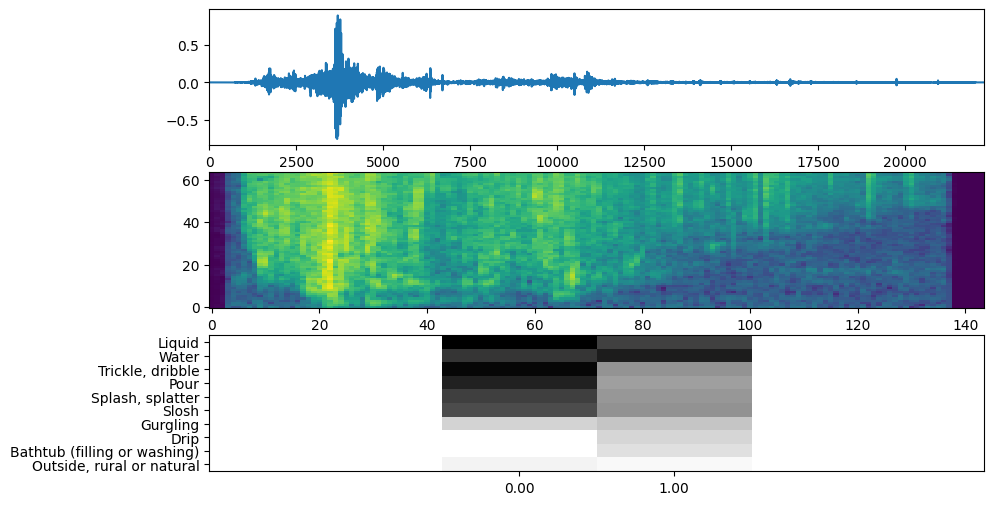

In [12]:
# Supponiamo che 'scores', 'scores_np', 'log_mel_spectrogram' e 'class_names' siano già definiti.
# 'exclude_classes' è la lista delle classi da escludere.

# Maschera i punteggi per escludere le classi selezionate (impostandole su un valore molto basso)
mask = np.ones_like(scores_np, dtype=np.float32)
mask[:, exclude_indices] = 0  # Impostiamo a 0 le classi da escludere

# Applicare la maschera ai punteggi
masked_scores = scores_np * mask

# Calcolare la media dei punteggi per ciascuna classe (dopo aver applicato la maschera)
mean_scores = np.mean(masked_scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]

# Creare il grafico
plt.figure(figsize=(10, 6))

# Plot del waveform
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot dello spettrogramma log-mel
plt.subplot(3, 1, 2)
plt.imshow(log_mel_spectrogram.numpy().T, aspect='auto', interpolation='nearest', origin='lower')

# Plot dei punteggi (senza le classi escluse)
plt.subplot(3, 1, 3)  # Sottogruppo 3 della griglia 3x1
plt.imshow(masked_scores[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# Calcolare il padding per le finestre
patch_padding = (segment_duration / 2) / hop_duration

# Calcolare i secondi per l'asse X (tempo per ogni finestra)
time_axis = np.arange(0, scores.shape[0] * hop_duration, hop_duration)

# Impostare i limiti dell'asse X con il padding
plt.xlim([-patch_padding - 0.5, scores.shape[0] + patch_padding - 0.5])

# Etichettare le classi top_n sull'asse Y
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])

# Etichettare l'asse X con i secondi (tempo)
xticks_step = int(scores.shape[0] / 10) if scores.shape[0] > 10 else 1
plt.xticks(np.arange(0, scores.shape[0], xticks_step),
           labels=[f"{time:.2f}" for time in time_axis[::xticks_step]])


# Impostare i limiti dell'asse Y per centrare le etichette delle classi
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

# Mostrare il grafico
plt.show()

# MODELLO CON SOLO SOTTOGRUPPI DI LABEL

In [13]:
import json

# Percorso del file JSON
config_json = '/content/drive/MyDrive/SonART/Code/conf_label_sounds.json'

# Carica il file JSON
with open(config_json, 'r') as file:
    subgroups = json.load(file)

# Seleziona un sottogruppo (esempio: "Sea")
selected_subgroup = "Custom"
selected_classes = subgroups[selected_subgroup]

print(f"Classi selezionate per il sottogruppo '{selected_subgroup}': {selected_classes}")


Classi selezionate per il sottogruppo 'Custom': ['Heart sounds, heartbeat', 'Cat', 'Ocean', 'Slosh', 'Bird flight, flapping wings', 'Vehicle', 'Crack', 'Bell', 'Dog']


In [14]:
for segment in segments:
  # Caricamento del modello e dati delle classi
  scores, embeddings, log_mel_spectrogram = model(segment)
  class_map_path = model.class_map_path().numpy()
  class_names = class_names_from_csv(tf.io.read_file(class_map_path).numpy().decode('utf-8'))

  # Filtrare gli indici delle classi selezionate
  selected_indices = [class_names.index(cls) for cls in selected_classes if cls in class_names]

  # Convertire i punteggi in NumPy
  scores_np = scores.numpy()

  # Impostare a -1 le classi non selezionate
  scores_np[:, [i for i in range(scores_np.shape[1]) if i not in selected_indices]] = -1

  # Previsione della classe con punteggio massimo
  predicted_class_index = np.argmax(np.mean(scores_np[:, selected_indices], axis=0))
  predicted_class = class_names[selected_indices[predicted_class_index]]

  # Stampa della previsione
  print(f"Classe predetta per il sottogruppo '{selected_subgroup}': {predicted_class}")



Classe predetta per il sottogruppo 'Custom': Slosh


# COMUNICAZIONE OSC

In [ ]:
!pip install python-osc pyngrok

In [ ]:
from pythonosc import udp_client
from pyngrok import ngrok

# Configura l'authtoken (sostituisci con il tuo token)
!ngrok config add-authtoken 2qTZCNO8n2oFvgstYsKzTkaRN9o_3WrRyM9gMV2JJ9ZhDSszJ

tcp_port = 12000
public_url = ngrok.connect(tcp_port, "tcp")
print(f"Collega Processing a questo indirizzo: {public_url}")


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


PyngrokNgrokHTTPError: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: You must add a credit or debit card before you can use TCP endpoints on a free account. We require a valid card as a way to combat abuse and keep the internet a safe place. This card will NOT  be charged.\nAdd a card to your account here: https://dashboard.ngrok.com/settings#id-verification\r\n\r\nERR_NGROK_8013\r\n"}}


In [ ]:
pip install python-osc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.8 MB/s eta 0:00:00


In [ ]:
from pythonosc import udp_client
import time

ip = "127.0.0.1"
port = 12000

client = udp_client.SimpleUDPClient(ip, port)

for i in range(100):
    client.send_message("/image", "barca");
    time.sleep(1)